### Look at encounter durations to check how long patients are in hospital, for both RRT & non-RRT encounters.
#### When this was first done, we did not use the checkin time from the checkin table, where appropriate. Fixed here.
#### Starts with looking at the durations for the data we used in model, for rrt & non-rrt. Then goes bigger picture, to show subsets of data.

In [113]:
import pandas as pd
import numpy as np

In [1]:
from impala.util import as_pandas

In [2]:
# connect to impala
from impala.dbapi import connect
conn = connect(host='socbddn01.sharp.com', port=21050)

In [3]:
# Make sure we're pulling from the right location
cur = conn.cursor()
cur.execute('use poc_sandbox')


In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('ggplot')

In [5]:
# # Show tables to verify you're actually pulling from sandbox
# cur.execute('SHOW TABLES')
# cur.fetchall()

### Quick numbers: # RRT events & total # encounters (for Sharp Memorial)
#### For all patient & location types

In [6]:
query_TotalEncs = "SELECT count(1) from  ( SELECT DISTINCT encntr_id \
                       FROM encounter \
                      WHERE encntr_complete_dt_tm < 4000000000000 \
                       AND loc_facility_cd = '633867' \
                      ) t;"

cur.execute(query_TotalEncs)
cur.fetchall()

[(604218,)]

#### For admit_type_cd!='0' & encntr_type_class_cd='391

In [7]:
query_TotalEncs = '''SELECT count(1) from  ( SELECT DISTINCT encntr_id
                    FROM encounter
                    WHERE encntr_complete_dt_tm < 4e12
                    AND loc_facility_cd = '633867'
                    AND admit_type_cd!='0'
                    AND encntr_type_class_cd='391'
                      ) t;'''

cur.execute(query_TotalEncs)
cur.fetchall()

[(29900,)]

### Examining distribution of encounter durations (with loc_facility_cd)
#### Analyze the durations of the RRT event patients.

In [8]:
query_count = '''SELECT count(*) FROM (
                    SELECT DISTINCT ce.encntr_id
                    FROM clinical_event ce
                    INNER JOIN encounter enc ON enc.encntr_id = ce.encntr_id
                    WHERE ce.event_cd = '54411998'
                    AND ce.result_status_cd NOT IN ('31', '36')
                    AND ce.valid_until_dt_tm > 4e12
                    AND ce.event_class_cd not in ('654645')
                    AND enc.loc_facility_cd = '633867'
                    AND enc.encntr_complete_dt_tm < 4e12
                    AND enc.admit_type_cd!='0'
                    AND enc.encntr_type_class_cd='391'
                    ) AS A ;'''
cur.execute(query_count)
cur.fetchall()

[(1702,)]

In [9]:
query_count = '''SELECT count(*) FROM
                    (SELECT DISTINCT encntr_id
                    FROM encounter enc
                    WHERE enc.loc_facility_cd = '633867'
                    AND enc.encntr_complete_dt_tm < 4e12
                    AND enc.admit_type_cd!='0'
                    AND enc.encntr_type_class_cd='391'
                    AND encntr_id NOT IN (SELECT DISTINCT ce.encntr_id
                                        FROM clinical_event ce
                                        INNER JOIN encounter enc ON enc.encntr_id = ce.encntr_id
                                        WHERE ce.event_cd = '54411998'
                                        AND ce.result_status_cd NOT IN ('31', '36')
                                        AND ce.valid_until_dt_tm > 4e12
                                        AND ce.event_class_cd not in ('654645')
                                          )
                    ) AS A
                    ;'''
cur.execute(query_count)
cur.fetchall()

[(28198,)]

### Let's look at durations for inpatients WITH RRTs from Sharp Memorial Hospital where encounter_admit_type is not zero

In [40]:
query = '''SELECT DISTINCT ce.encntr_id, COALESCE(tci.checkin_dt_tm, enc.arrive_dt_tm) AS checkin_dt_tm
            ,enc.depart_dt_tm as depart_dt_tm
            ,(enc.depart_dt_tm - COALESCE(tci.checkin_dt_tm, enc.arrive_dt_tm))/3600000 AS diff_hours
            ,enc.reason_for_visit, enc.admit_src_cd, enc.admit_type_cd
FROM clinical_event ce 
INNER JOIN encounter enc ON enc.encntr_id = ce.encntr_id
LEFT OUTER JOIN  ( 
                    SELECT  ti.encntr_id AS encntr_id,   MIN(tc.checkin_dt_tm)  AS checkin_dt_tm
                    FROM tracking_item ti
                    JOIN tracking_checkin  tc ON  ti.tracking_id  = tc.tracking_id
                    GROUP BY ti.encntr_id 
                  ) tci
                    ON tci.encntr_id = enc.encntr_id
            
WHERE enc.loc_facility_cd = '633867'
    AND enc.encntr_complete_dt_tm < 4e12
    AND enc.admit_type_cd!='0'
    AND enc.encntr_type_class_cd='391'
AND enc.encntr_id IN ( SELECT DISTINCT ce.encntr_id
                    FROM clinical_event ce
                    WHERE ce.event_cd = '54411998'
                    AND ce.result_status_cd NOT IN ('31', '36')
                    AND ce.valid_until_dt_tm > 4e12
                    AND ce.event_class_cd not in ('654645') )
;'''

In [41]:
cur.execute(query)
df_rrt = as_pandas(cur)

In [42]:
df_rrt.head()

,encntr_id,checkin_dt_tm,depart_dt_tm,diff_hours,reason_for_visit,admit_src_cd,admit_type_cd
0,110251028,1466927820000,1467447000000,144.216667,NEUTROPENIC FEVER,42327663,670839
1,99589739,1440473820000,1440750360000,76.816667,CHEST PAIN,42327663,670839
2,96248070,1431942960000,1432801680000,238.533333,CHRONIC OBSTRUCTIVE PULMONARY DISEASE EXACERBA...,309196,670839
3,100855950,1443679380000,1445924400000,623.616667,ANEMIA,0,309203
4,106952710,1461701280000,1462853700000,320.116667,CERVICAL SPONDYLOSIS RADICULOPATHY MYELOPATHY,309196,670840


In [43]:
df_rrt.describe().T
# the mean stay is 292 hours (12.1 days).
# The median stay is 184 hours (7.67 days)
# The minimum stay is 8 hours. The longest stay is 3550 hours (~148 days)

,count,mean,std,min,25%,50%,75%,max
checkin_dt_tm,1702.0,1.444662e+12,1.483684e+10,1.410328e+12,1.431464e+12,1.445154e+12,1.457328e+12,1.470952e+12
depart_dt_tm,1702.0,1.445715e+12,1.486089e+10,1.410935e+12,1.432302e+12,1.446407e+12,1.458377e+12,1.471242e+12
diff_hours,1702.0,2.922786e+02,3.289526e+02,8.366667e+00,1.028625e+02,1.843333e+02,3.384292e+02,3.550633e+03


<IPython.core.display.Javascript object>


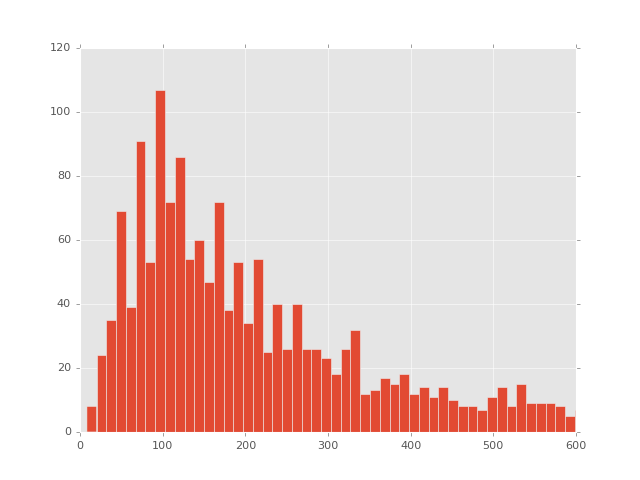

(0, 600)

In [45]:
plt.figure()
df_rrt.diff_hours.hist(bins = 300)
plt.xlim(0, 600)

In [46]:
# Records with short durations:
df_rrt[df_rrt.diff_hours < 12]

,encntr_id,checkin_dt_tm,depart_dt_tm,diff_hours,reason_for_visit,admit_src_cd,admit_type_cd
322,98496244,1437684780000,1437714900000,8.366667,"EMPHYSEMATOUS PYELONEPHRITIS, SEPSIS",309196,309203
1315,104755609,1453684200000,1453722900000,10.750000,SEPSIS,309196,670839


### Let's look at durations for inpatients WITHOUT RRTs from Sharp Memorial Hospital where encounter_admit_type is not zero

In [47]:
query = '''SELECT DISTINCT ce.encntr_id, COALESCE(tci.checkin_dt_tm, enc.arrive_dt_tm) AS checkin_dt_tm
            ,enc.depart_dt_tm as depart_dt_tm
            ,(enc.depart_dt_tm - COALESCE(tci.checkin_dt_tm, enc.arrive_dt_tm))/3600000 AS diff_hours
            ,enc.reason_for_visit, enc.admit_src_cd, enc.admit_type_cd
FROM clinical_event ce 
INNER JOIN encounter enc ON enc.encntr_id = ce.encntr_id
LEFT OUTER JOIN  ( 
                    SELECT  ti.encntr_id AS encntr_id,   MIN(tc.checkin_dt_tm)  AS checkin_dt_tm
                    FROM tracking_item ti
                    JOIN tracking_checkin  tc ON  ti.tracking_id  = tc.tracking_id
                    GROUP BY ti.encntr_id 
                  ) tci
                    ON tci.encntr_id = enc.encntr_id
            
WHERE enc.loc_facility_cd = '633867'
    AND enc.encntr_complete_dt_tm < 4e12
    AND enc.admit_type_cd!='0'
    AND enc.encntr_type_class_cd='391'
AND enc.encntr_id NOT IN ( SELECT DISTINCT ce.encntr_id
                    FROM clinical_event ce
                    WHERE ce.event_cd = '54411998'
                    AND ce.result_status_cd NOT IN ('31', '36')
                    AND ce.valid_until_dt_tm > 4e12
                    AND ce.event_class_cd not in ('654645') )
;'''

In [48]:
cur.execute(query)
df_nonrrt = as_pandas(cur)

In [49]:
df_nonrrt.describe().T
# NonRRT: The mean stay is 122 hours (5 days) // RRT: The mean stay is 292 hours (12.1 days).
# NonRRT: The median stay is 77 hours (3.21 days)// RRT: The median stay is 184 hours (7.67 days)
# NonRRT: The minimum stay is 0.08 hours // RRT: The minimum stay is ~8 hours.

,count,mean,std,min,25%,50%,75%,max
checkin_dt_tm,28072.0,1.444905e+12,1.529949e+10,1.340101e+12,1.431938e+12,1.445375e+12,1.457929e+12,1.471315e+12
depart_dt_tm,28072.0,1.445343e+12,1.527579e+10,1.340509e+12,1.432363e+12,1.445745e+12,1.458292e+12,1.471462e+12
diff_hours,28072.0,1.216180e+02,1.700211e+02,8.333333e-02,5.030000e+01,7.770000e+01,1.309750e+02,7.937100e+03


In [52]:
# df_nonrrt[df_nonrrt.diff_hours < 6]

<IPython.core.display.Javascript object>


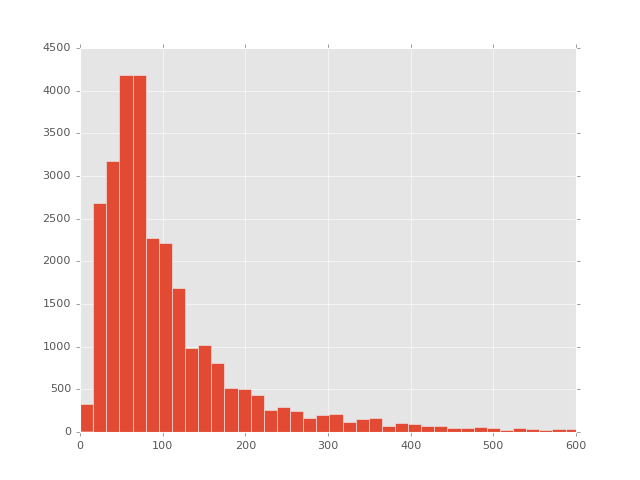

(0, 600)

In [51]:
plt.figure()
df_nonrrt.diff_hours.hist(bins = 500)
plt.xlim(0, 600)

### Plot both together to see how encounter duration distributions are different

<IPython.core.display.Javascript object>


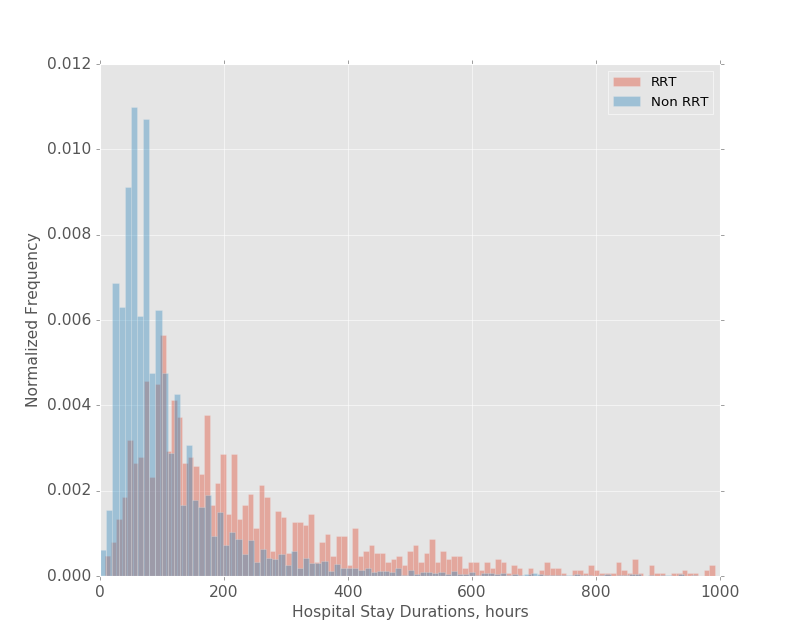

(0, 1000)

In [74]:
plt.figure(figsize = (10,8))
df_rrt.diff_hours.plot.hist(alpha=0.4, bins=400,normed=True)
df_nonrrt.diff_hours.plot.hist(alpha=0.4, bins=800,normed=True)
plt.xlabel('Hospital Stay Durations, hours', fontsize=14)
plt.ylabel('Normalized Frequency', fontsize=14)
plt.legend(['RRT', 'Non RRT'])
plt.tick_params(labelsize=14)
plt.xlim(0, 1000)

## Even accounting for the hospital, inpatients status, and accounting for some admit_type_cd, the durations are still quite different betwen RRT & non-RRT.
### Trying some subset vizualizations -- these show no difference

In [63]:
print df_nonrrt.admit_type_cd.value_counts()
print
print df_rrt.admit_type_cd.value_counts()

670839     13677
309203      8116
670840      6254
4659953       17
4659952        5
4659954        3
Name: admit_type_cd, dtype: int64

670839     902
309203     584
670840     215
4659953      1
Name: admit_type_cd, dtype: int64


In [64]:
print df_nonrrt.admit_src_cd.value_counts()
print
print df_rrt.admit_src_cd.value_counts()

309196      21602
0            3909
15695295      760
42327663      593
15694351      525
52604023      132
42326610      131
4659941       121
4659943        74
4659928        72
4659916        36
4659942        35
4659945        33
4659946        25
309201         12
309194          3
42326433        2
42326212        2
42326505        2
4659944         1
42327381        1
309193          1
Name: admit_src_cd, dtype: int64

309196      1251
0            264
42327663      73
15695295      38
15694351      29
52604023       9
4659943        8
42326610       5
4659941        5
4659916        4
4659928        4
4659945        3
4659942        3
4659946        2
309201         2
309194         1
309193         1
Name: admit_src_cd, dtype: int64


<IPython.core.display.Javascript object>


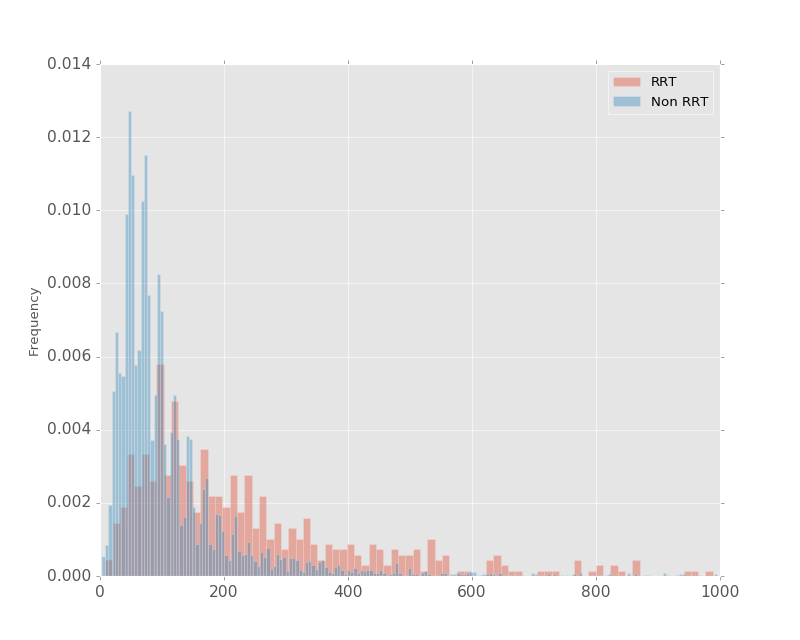

(0, 1000)

In [67]:
plt.figure(figsize = (10,8))
df_rrt[df_rrt.admit_type_cd=='309203'].diff_hours.plot.hist(alpha=0.4, bins=300,normed=True)
df_nonrrt[df_nonrrt.admit_type_cd=='309203'].diff_hours.plot.hist(alpha=0.4, bins=600,normed=True)
# plt.xlabel('Hospital Stay Durations, hours', fontsize=14)
# plt.ylabel('Normalized Frequency', fontsize=14)
plt.legend(['RRT', 'Non RRT'])
# plt.legend(["Sharp Memorial", "Sharp Grossmont", "Sharp Chula Vista"])
plt.tick_params(labelsize=14)
plt.xlim(0, 1000)

<IPython.core.display.Javascript object>


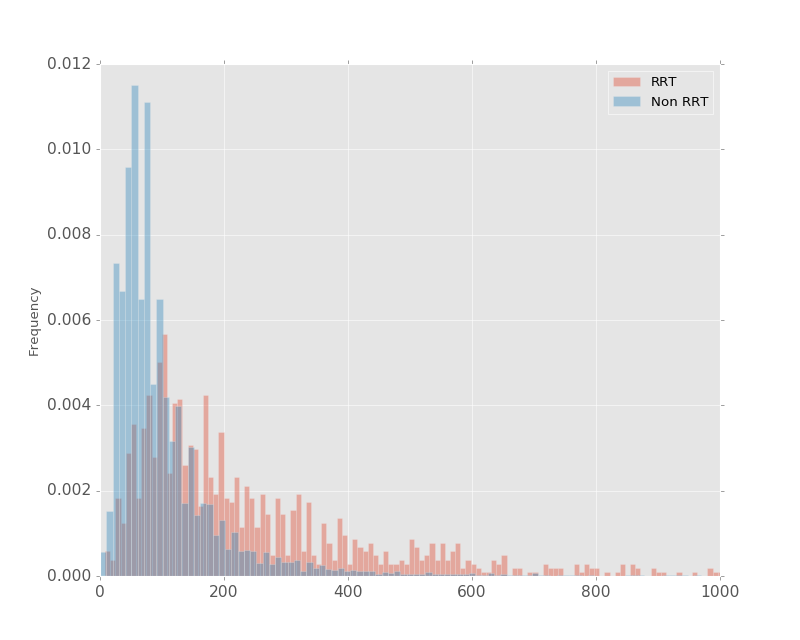

(0, 1000)

In [68]:
plt.figure(figsize = (10,8))
df_rrt[df_rrt.admit_src_cd=='309196'].diff_hours.plot.hist(alpha=0.4, bins=300,normed=True)
df_nonrrt[df_nonrrt.admit_src_cd=='309196'].diff_hours.plot.hist(alpha=0.4, bins=600,normed=True)
# plt.xlabel('Hospital Stay Durations, days', fontsize=14)
# plt.ylabel('Normalized Frequency', fontsize=14)
plt.legend(['RRT', 'Non RRT'])
plt.tick_params(labelsize=14)
plt.xlim(0, 1000)

# Despite controlling for patient parameters, patients with RRT events stay in the hospital longer than non-RRT event having patients.

## Rerun previous EDA on hospital & patient types

### Let's take a step back and look at the encounter table, for all hospitals and patient types [but using corrected time duration].

In [179]:
# For encounters with RRT events
query = '''SELECT DISTINCT ce.encntr_id, COALESCE(tci.checkin_dt_tm, enc.arrive_dt_tm) AS checkin_dt_tm
            ,enc.depart_dt_tm as depart_dt_tm
            ,(enc.depart_dt_tm - COALESCE(tci.checkin_dt_tm, enc.arrive_dt_tm))/3600000 AS diff_hours
            ,enc.reason_for_visit, enc.admit_type_cd, cv_admit_type.description as admit_type_desc
            ,enc.encntr_type_cd, cv_enc_type.description as enc_type_desc
            ,enc.encntr_type_class_cd, cv_enc_type_class.description as enc_type_class_desc
            ,enc.admit_src_cd, cv_admit_src.description as admit_src_desc
            ,enc.loc_facility_cd, cv_loc_fac.description as loc_desc
FROM clinical_event ce 
INNER JOIN encounter enc ON enc.encntr_id = ce.encntr_id
LEFT OUTER JOIN code_value cv_admit_type ON enc.admit_type_cd = cv_admit_type.code_value
LEFT OUTER JOIN code_value cv_enc_type ON enc.encntr_type_cd = cv_enc_type.code_value
LEFT OUTER JOIN code_value cv_enc_type_class ON enc.encntr_type_class_cd = cv_enc_type_class.code_value
LEFT OUTER JOIN code_value cv_admit_src ON enc.admit_src_cd = cv_admit_src.code_value
LEFT OUTER JOIN code_value cv_loc_fac ON enc.loc_facility_cd = cv_loc_fac.code_value
LEFT OUTER JOIN  ( 
                    SELECT  ti.encntr_id AS encntr_id,   MIN(tc.checkin_dt_tm)  AS checkin_dt_tm
                    FROM tracking_item ti
                    JOIN tracking_checkin  tc ON  ti.tracking_id  = tc.tracking_id
                    GROUP BY ti.encntr_id 
                  ) tci
                    ON tci.encntr_id = enc.encntr_id
            
WHERE enc.encntr_id IN ( SELECT DISTINCT ce.encntr_id
                    FROM clinical_event ce
                    WHERE ce.event_cd = '54411998'
                    AND ce.result_status_cd NOT IN ('31', '36')
                    AND ce.valid_until_dt_tm > 4e12
                    AND ce.event_class_cd not in ('654645') )
;'''

In [180]:
cur.execute(query)
df = as_pandas(cur)

In [181]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
checkin_dt_tm,3447.0,1.445504e+12,1.525757e+10,1.292685e+12,1.432355e+12,1.446297e+12,1.458399e+12,1.471382e+12
depart_dt_tm,3400.0,1.446289e+12,1.508027e+10,1.293351e+12,NaN,NaN,NaN,1.471503e+12
diff_hours,3400.0,2.935407e+02,3.748575e+02,0.000000e+00,NaN,NaN,NaN,9.082333e+03


In [182]:
# check nulls
print df[pd.isnull(df.diff_hours)].count()
print 
print df[~pd.isnull(df.diff_hours)].count()

encntr_id               47
checkin_dt_tm           47
depart_dt_tm             0
diff_hours               0
reason_for_visit        47
admit_type_cd           47
admit_type_desc          3
encntr_type_cd          47
enc_type_desc           47
encntr_type_class_cd    47
enc_type_class_desc     47
admit_src_cd            47
admit_src_desc          34
loc_facility_cd         47
loc_desc                47
dtype: int64

encntr_id               3400
checkin_dt_tm           3400
depart_dt_tm            3400
diff_hours              3400
reason_for_visit        3400
admit_type_cd           3400
admit_type_desc         3272
encntr_type_cd          3400
enc_type_desc           3400
encntr_type_class_cd    3400
enc_type_class_desc     3400
admit_src_cd            3400
admit_src_desc          2704
loc_facility_cd         3400
loc_desc                3400
dtype: int64


In [183]:
df[pd.isnull(df.diff_hours)]

,encntr_id,checkin_dt_tm,depart_dt_tm,diff_hours,reason_for_visit,admit_type_cd,admit_type_desc,encntr_type_cd,enc_type_desc,encntr_type_class_cd,enc_type_class_desc,admit_src_cd,admit_src_desc,loc_facility_cd,loc_desc
37,110941074,1468660980000,NaN,NaN,THROMBOCYTOPENIA,670839,Urgent,4603595,(IPE) Emergency - IP,391,Inpatient,309196,Home/Physician Referral,4382273,Sharp Chula Vista Medical Center
158,111940172,1471243320000,NaN,NaN,ACTUE SEPSIS,0,None,4603595,(IPE) Emergency - IP,391,Inpatient,309196,Home/Physician Referral,633867,Sharp Memorial Hospital
198,83727342,1399039320000,NaN,NaN,FALL/RIGHT LC1 PELVIC RING INJURY,0,None,4603601,(IPS) IP Skilled Nursing,391,Inpatient,309201,SNF Transfer,4382273,Sharp Chula Vista Medical Center
244,110944148,1468674840000,NaN,NaN,ACUTE CHEST PAIN,0,None,4603595,(IPE) Emergency - IP,391,Inpatient,309196,Home/Physician Referral,4382273,Sharp Chula Vista Medical Center
253,111531822,1470203100000,NaN,NaN,TWISTER ACUTE FLARE OF CHRONIC NECROTIZING PAN...,0,None,4603595,(IPE) Emergency - IP,391,Inpatient,309196,Home/Physician Referral,4382273,Sharp Chula Vista Medical Center
327,106007245,1456564560000,NaN,NaN,"SEPSIS DUE TO URINARY TRACT INFECTION,SACRAL D...",0,None,4603595,(IPE) Emergency - IP,391,Inpatient,309196,Home/Physician Referral,633867,Sharp Memorial Hospital
355,111695162,1470659100000,NaN,NaN,"CHEST PAIN, BACK PAIN",0,None,4603595,(IPE) Emergency - IP,391,Inpatient,0,None,4382264,Sharp Grossmont Hospital
395,111598886,1470356640000,NaN,NaN,"ALCOHOLIC KETOACIDOSIS, SEIZURE, HEMATEMESIS",0,None,4603595,(IPE) Emergency - IP,391,Inpatient,0,None,4382264,Sharp Grossmont Hospital
521,111942846,1471296540000,NaN,NaN,"SLURRED SPEECH,TRANSIENT ISCHEMIC ATTACK,DYSPNEA",0,None,4603595,(IPE) Emergency - IP,391,Inpatient,0,None,4382264,Sharp Grossmont Hospital
595,111983023,1471339980000,NaN,NaN,SEPSIS,0,None,4603595,(IPE) Emergency - IP,391,Inpatient,309196,Home/Physician Referral,633867,Sharp Memorial Hospital


In [184]:
# can't work with the nans in there... delete these rows
print df.shape
df = df[~pd.isnull(df['depart_dt_tm'])]
df = df.reset_index(drop=True)
print df.shape

(3447, 15)
(3400, 15)


In [185]:
df.describe().T
# RRT encounters for all patients/hospitals
# All RRT: mean stay: 293.5 hours // NonRRT: The mean stay is 122 hours (5 days) // RRT: The mean stay is 292 hours (12.1 days).
# All RRT: median stay: 190 hours // NonRRT: The median stay is 77 hours (3.21 days)// RRT: The median stay is 184 hours (7.67 days)
# All RRT: min stay: 0 hours // NonRRT: The minimum stay is 0.08 hours // RRT: The minimum stay is ~8 hours.

,count,mean,std,min,25%,50%,75%,max
checkin_dt_tm,3400.0,1.445232e+12,1.505689e+10,1.292685e+12,1.432233e+12,1.445915e+12,1.458000e+12,1.471212e+12
depart_dt_tm,3400.0,1.446289e+12,1.508027e+10,1.293351e+12,1.433388e+12,1.447228e+12,1.459090e+12,1.471503e+12
diff_hours,3400.0,2.935407e+02,3.748575e+02,0.000000e+00,1.043958e+02,1.896333e+02,3.444167e+02,9.082333e+03


In [186]:
# Let's be suspicious of short encounters, say, under 6 hours.
# There are two cases where the number of hours = 0, these both have admit_type_cd=0, loc_facility_cd = 4382287. & ecntr_type_class_cd=393
df[df.diff_hours < 6]

,encntr_id,checkin_dt_tm,depart_dt_tm,diff_hours,reason_for_visit,admit_type_cd,admit_type_desc,encntr_type_cd,enc_type_desc,encntr_type_class_cd,enc_type_class_desc,admit_src_cd,admit_src_desc,loc_facility_cd,loc_desc
1014,106271242,1457313000000,1.457331e+12,5.000000,"CHEST PAIN,NEAR SYNCOPE",670839,Urgent,4603595,(IPE) Emergency - IP,391,Inpatient,309196,Home/Physician Referral,4382273,Sharp Chula Vista Medical Center
1385,104279302,1452575100000,1.452596e+12,5.833333,. . .RIGHT ANKLE PAIN,0,None,4603596,(OPE) Emergency - OP,393,Outpatient,0,None,4382264,Sharp Grossmont Hospital
1649,103925388,1451542620000,1.451543e+12,0.000000,,0,None,4603632,(ZZZ) SRS Clinic Visit,393,Outpatient,0,None,4382287,Sharp Rees-Stealy Medical Group
1976,101478690,1447287720000,1.447301e+12,3.633333,LEFT KNEE OSTEOARTHRITIS,0,None,4603613,(OPS) OP Surgery (No Bed),393,Outpatient,309196,Home/Physician Referral,633867,Sharp Memorial Hospital
2068,102076074,1446597720000,1.446604e+12,1.816667,SEIZURE,0,None,4603596,(OPE) Emergency - OP,393,Outpatient,309196,Home/Physician Referral,633867,Sharp Memorial Hospital
2465,102724852,1448070360000,1.448083e+12,3.566667,ELEVATED WHITE BLOOD COUNT,670839,Urgent,4603600,(IPR) IP Regular,391,Inpatient,0,None,4382264,Sharp Grossmont Hospital
2856,96047018,1431407280000,1.431407e+12,0.000000,,0,None,4603632,(ZZZ) SRS Clinic Visit,393,Outpatient,0,None,4382287,Sharp Rees-Stealy Medical Group
3037,105545361,1456966980000,1.456986e+12,5.283333,LEFT THUMB INFECTION,0,None,4603613,(OPS) OP Surgery (No Bed),393,Outpatient,309196,Home/Physician Referral,4382264,Sharp Grossmont Hospital
3207,109305658,1464671640000,1.464681e+12,2.533333,MEDICAL CLEARANCE/DEPRESSION,0,None,4603596,(OPE) Emergency - OP,393,Outpatient,309196,Home/Physician Referral,633867,Sharp Memorial Hospital


### The notebook Probe_encounter_types_classes explores admit type, class types & counts

<IPython.core.display.Javascript object>


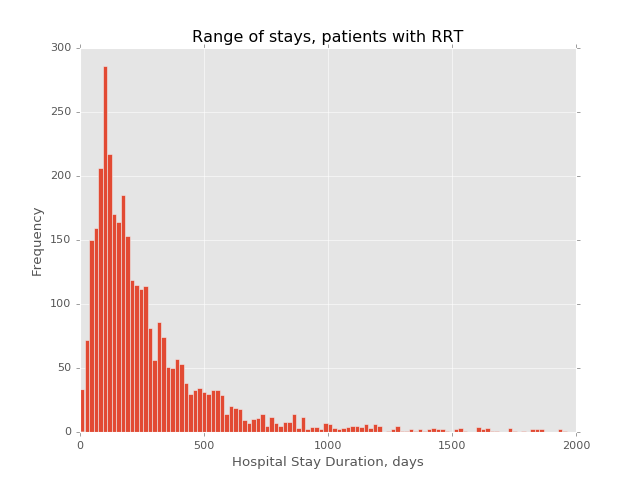

(0, 2000)

In [192]:
plt.figure()
df['diff_hours'].plot.hist(bins=500)
plt.xlabel("Hospital Stay Duration, days")
plt.title("Range of stays, patients with RRT")
plt.xlim(0, 2000)

## Group by facility
### We want to pull from similar patient populations

In [193]:
df.head()

,encntr_id,checkin_dt_tm,depart_dt_tm,diff_hours,reason_for_visit,admit_type_cd,admit_type_desc,encntr_type_cd,enc_type_desc,encntr_type_class_cd,enc_type_class_desc,admit_src_cd,admit_src_desc,loc_facility_cd,loc_desc
0,103746702,1450861380000,1.451020e+12,44.200000,PNUEMONIA,670839,Urgent,4603595,(IPE) Emergency - IP,391,Inpatient,42326610,Assisted Living Fac,633867,Sharp Memorial Hospital
1,93025467,1424382240000,1.425023e+12,177.900000,"LEFT HIP DYSPLASIA,LEFT HIP DERANGEMENT",670839,Urgent,4603600,(IPR) IP Regular,391,Inpatient,309196,Home/Physician Referral,633867,Sharp Memorial Hospital
2,103034699,1449037620000,1.450795e+12,488.100000,"CHEST PAIN, MYOCARDIAL INFARCTION",670839,Urgent,4603595,(IPE) Emergency - IP,391,Inpatient,0,None,4382264,Sharp Grossmont Hospital
3,107701412,1460640480000,1.461209e+12,157.950000,"SEIZURE, URINARY TRACT INFECTION",670839,Urgent,4603595,(IPE) Emergency - IP,391,Inpatient,309196,Home/Physician Referral,4382273,Sharp Chula Vista Medical Center
4,108127253,1461729420000,1.462411e+12,189.366667,HYPERLIPIDEMIA/GERD/OBESITY,670840,Elective,4603601,(IPS) IP Skilled Nursing,391,Inpatient,4659941,Sharp Chula Vista Acute Care,4382273,Sharp Chula Vista Medical Center


In [194]:
df.loc_desc.value_counts()

Sharp Memorial Hospital                             1775
Sharp Chula Vista Medical Center                     997
Sharp Grossmont Hospital                             582
Sharp Coronado Hospital and Healthcare Center         23
Sharp Mary Birch Hospital for Women and Newborns      21
Sharp Rees-Stealy Medical Group                        2
Name: loc_desc, dtype: int64

In [197]:
grouped = df.groupby('loc_desc')

In [198]:
grouped.describe()

checkin_dt_tm  \
loc_desc                                                                
Sharp Chula Vista Medical Center                 count   9.970000e+02   
                                                 mean    1.445386e+12   
                                                 std     1.467313e+10   
                                                 min     1.367165e+12   
                                                 25%     1.433041e+12   
                                                 50%     1.446001e+12   
                                                 75%     1.458006e+12   
                                                 max     1.471047e+12   
Sharp Coronado Hospital and Healthcare Center    count   2.300000e+01   
                                                 mean    1.446484e+12   
                                                 std     1.319497e+10   
                                                 min     1.422049e+12   
                                                 25%     1.436157e+12   
                                                 50%     1.448963e+12   
                                                 75%     1.457083e+12   
                                                 max     1.463605e+12   
Sharp Grossmont Hospital                         count   5.820000e+02   
                                                 mean    1.446035e+12   
                                                 std     1.507939e+10   
                                                 min     1.419518e+12   
                                                 25%     1.433059e+12   
                                                 50%     1.447146e+12   
                                                 75%     1.458942e+12   
                                                 max     1.471212e+12   
Sharp Mary Birch Hospital for Women and Newborns count   2.100000e+01   
                                                 mean    1.449458e+12   
                                                 std     1.425954e+10   
                                                 min     1.421972e+12   
                                                 25%     1.438431e+12   
                                                 50%     1.449126e+12   
                                                 75%     1.464300e+12   
                                                 max     1.468459e+12   
Sharp Memorial Hospital                          count   1.775000e+03   
                                                 mean    1.444821e+12   
                                                 std     1.529118e+10   
                                                 min     1.292685e+12   
                                                 25%     1.431623e+12   
                                                 50%     1.445478e+12   
                                                 75%     1.457665e+12   
                                                 max     1.470952e+12   
Sharp Rees-Stealy Medical Group                  count   2.000000e+00   
                                                 mean    1.441475e+12   
                                                 std     1.423784e+10   
                                                 min     1.431407e+12   
                                                 25%     1.436441e+12   
                                                 50%     1.441475e+12   
                                                 75%     1.446509e+12   
                                                 max     1.451543e+12   

                                                        depart_dt_tm  \
loc_desc                                                               
Sharp Chula Vista Medical Center                 count  9.970000e+02   
                                                 mean   1.446481e+12   
                                                 std    1.466718e+10   
                                             

### Most number of results from 633867, or Sharp Memorial Hospital

<IPython.core.display.Javascript object>


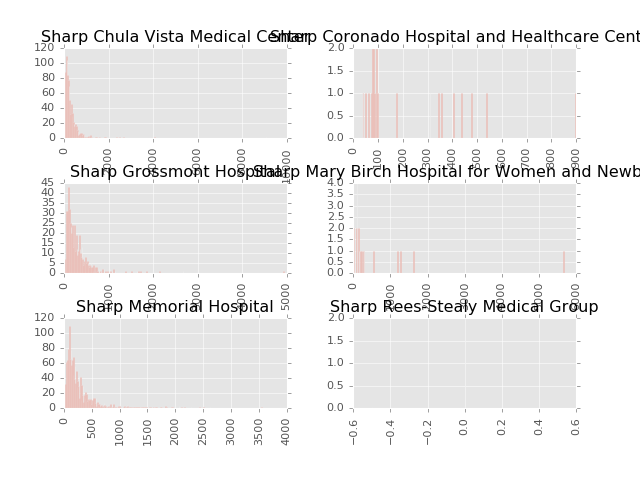

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd200563e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd206eca110>]], dtype=object)

In [200]:
df.diff_hours.hist(by=df.loc_desc, bins=300)

In [174]:
# Use locations 4382264, 4382273, 633867

<IPython.core.display.Javascript object>


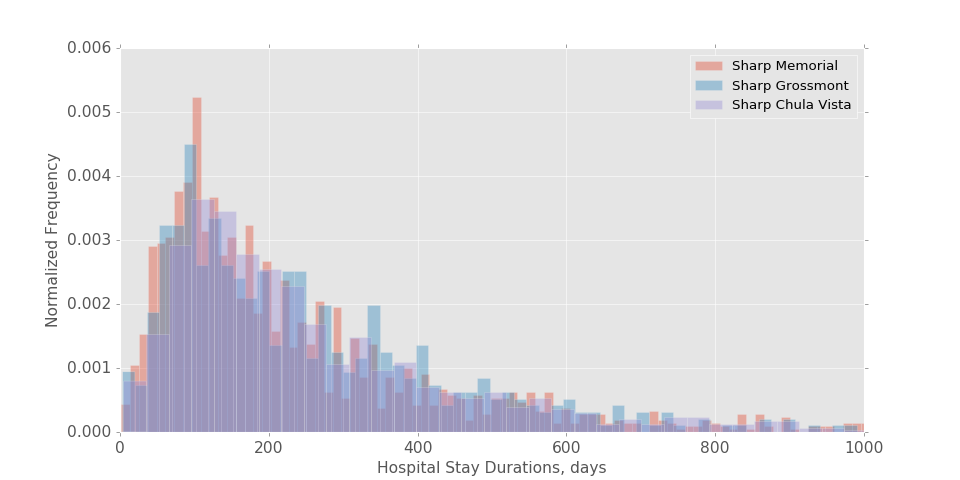

(0, 1000)

In [202]:
plt.figure(figsize=(12, 6))
df[df['loc_facility_cd']=='633867']['diff_hours'].plot.hist(alpha=0.4, bins=300,normed=True)
df[df['loc_facility_cd']=='4382264']['diff_hours'].plot.hist(alpha=0.4, bins=300,normed=True)
df[df['loc_facility_cd']=='4382273']['diff_hours'].plot.hist(alpha=0.4, bins=300,normed=True)
plt.xlabel('Hospital Stay Durations, days', fontsize=14)
plt.ylabel('Normalized Frequency', fontsize=14)
# plt.legend(['633867', '4382264', '4382273'])
plt.legend(["Sharp Memorial", "Sharp Grossmont", "Sharp Chula Vista"])
plt.tick_params(labelsize=14)
plt.xlim(0, 1000)

## Looks like these three locations (633867, 4382264, 4382273) have about the same distribution. 
#### Appropriate test to verify this: 2-sample Kolmogorov-Smirnov, if you're willing to compare pairwise...other tests? Wikipedia has a good article with references: https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test. Null hypothesis: the samples come from the same distribution. The null hypothesis is rejected if the test statistic is greater than the critical value (see wiki article)


In [203]:
from scipy.stats import ks_2samp

In [204]:
ks_2samp(df[df['loc_facility_cd']=='633867']['diff_hours'],df[df['loc_facility_cd']=='4382264']['diff_hours'])

Ks_2sampResult(statistic=0.074367165190455387, pvalue=0.014802754133457944)

In [ ]:
# Critical test statistic at alpha = 0.05: = 1.36 * sqrt((n1+n2)/n1*n2) = 1.36*(sqrt((1775+582)/(1775*582)) = 0.065
# 0.074 > 0.065 -> null hypothesis rejected at level 0.05. --> histograms are different

In [145]:
ks_2samp(df[df['loc_facility_cd']=='4382264']['diff_hours'], df[df['loc_facility_cd']=='4382273']['diff_hours'])

Ks_2sampResult(statistic=0.051984131087420338, pvalue=0.26673101853491099)

In [ ]:
# Critical test statistic at alpha = 0.05: = 1.36 * sqrt((n1+n2)/n1*n2) = 1.36*(sqrt((997+582)/(997*582)) = 0.071
# 0.05 !> 0.071 -> fail to reject null hypothesis at level 0.05. --> histograms are similar

In [149]:
ks_2samp(df[df['loc_facility_cd']=='633867']['diff_hours'],df[df['loc_facility_cd']=='4382273']['diff_hours'])

Ks_2sampResult(statistic=0.094241598033537211, pvalue=2.1257173881179864e-05)

In [ ]:
# Critical test statistic at alpha = 0.05: = 1.36 * sqrt((n1+n2)/n1*n2) = 1.36*(sqrt((1775+997)/(1775*997)) = 0.054
# 0.094 > 0.054 -> null hypothesis rejected at level 0.05. --> histograms are different; p-value indicates they're very different

#### From scipy documentation: "If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same"
Null hypothesis: the distributions are the same.
Looks like samples from 4382273 are different... plot that & 633867

<IPython.core.display.Javascript object>


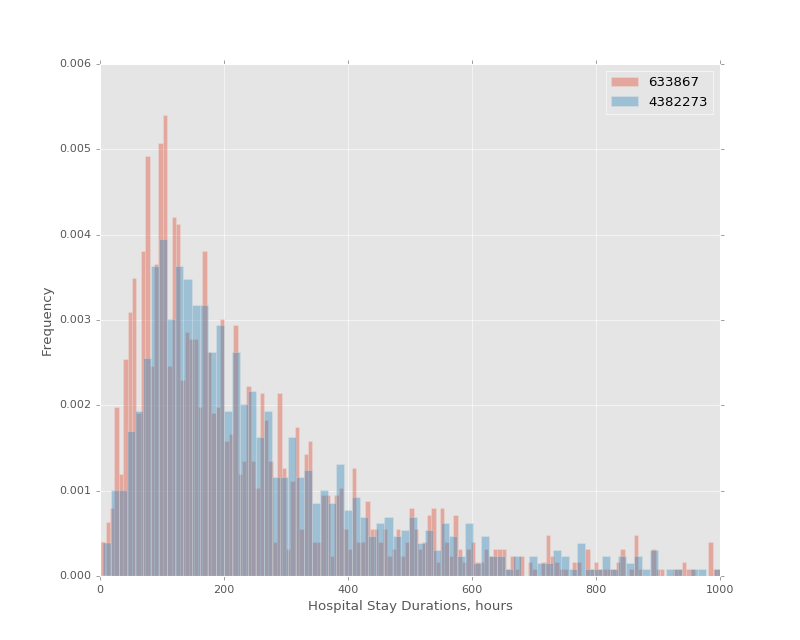

(0, 1000)

In [151]:
plt.figure(figsize=(10,8))
df[df['loc_facility_cd']=='633867']['diff_hours'].plot.hist(alpha=0.4, bins=500,normed=True)
df[df['loc_facility_cd']=='4382273']['diff_hours'].plot.hist(alpha=0.4, bins=700,normed=True)
plt.xlabel('Hospital Stay Durations, hours')
plt.legend(['633867', '4382273'])
plt.xlim(0, 1000)

# Let's compare encounter duration histograms for patients with RRT & without RRT events, and see if there is a right subset of data to be selected for modeling
### (There is)

In [208]:
df.columns

Index([u'encntr_id', u'checkin_dt_tm', u'depart_dt_tm', u'diff_hours',
       u'reason_for_visit', u'admit_type_cd', u'admit_type_desc',
       u'encntr_type_cd', u'enc_type_desc', u'encntr_type_class_cd',
       u'enc_type_class_desc', u'admit_src_cd', u'admit_src_desc',
       u'loc_facility_cd', u'loc_desc'],
      dtype='object')

In [209]:
df.admit_src_desc.value_counts()

Home/Physician Referral         2287
SNF Non Sharp                    179
NSI                               52
Trauma Eff 7-1-2010               37
NSE                               35
Sharp Chula Vista Acute Care      27
SNF Transfer                      20
Assisted Living Fac               18
Home Health                       17
Sharp Grossmont Acute Care         9
Board Care Facility                8
Sharp Memorial Acute Care          5
Sharp Coronado Acute Care          3
Sharp Mesa Vista Hospital          2
Emergency Room                     2
Hospice-POC or Prog/Home           1
Amb Surg/Non Hosp/ER               1
Court/Law Enforcement              1
Name: admit_src_desc, dtype: int64

In [ ]:
# Most common source codes (top 2) are undefined. next is SNF nonsharp; NSI ; Sharp Chula Vista Acute care ; ...

In [214]:
df.enc_type_class_desc.value_counts()
# vast majority are inpatient

Inpatient      3307
Observation      78
Outpatient       15
Name: enc_type_class_desc, dtype: int64

In [212]:
df.enc_type_desc.value_counts()

(IPE) Emergency - IP               2735
(IPR) IP Regular                    456
(OPI) Out Patient In a Bed           78
(IPZ) Trauma                         30
(IPW) Womens Serv IP                 29
(IPS) IP Skilled Nursing             27
(IPH) Rehab In a Bed                 25
(IPT) Transplant - IP                 5
(OPS) OP Surgery (No Bed)             5
(OPE) Emergency - OP                  5
(ZZZ) SRS Clinic Visit                2
(OPQ) OP Professional Charges         1
(OMS) Womens Serv OP Surg             1
(OMI) Outpatient In a Bed - MBH       1
Name: enc_type_desc, dtype: int64

In [215]:
df.admit_type_desc.value_counts()

Urgent                   2111
Emergency                 785
Elective                  352
Delivery, Unscheduled      14
Delivery, Scheduled         9
Unknown                     1
Name: admit_type_desc, dtype: int64

## Plot up rrt & non-rrt with different codes

In [219]:
# For encounters without RRT events, from Sharp Memorial.
# takes a while to run -- several minutes
query = '''SELECT DISTINCT ce.encntr_id, COALESCE(tci.checkin_dt_tm, enc.arrive_dt_tm) AS checkin_dt_tm
            ,enc.depart_dt_tm as depart_dt_tm
            ,(enc.depart_dt_tm - COALESCE(tci.checkin_dt_tm, enc.arrive_dt_tm))/3600000 AS diff_hours
            ,enc.reason_for_visit, enc.admit_type_cd, cv_admit_type.description as admit_type_desc
            ,enc.encntr_type_cd, cv_enc_type.description as enc_type_desc
            ,enc.encntr_type_class_cd, cv_enc_type_class.description as enc_type_class_desc
            ,enc.admit_src_cd, cv_admit_src.description as admit_src_desc
            ,enc.loc_facility_cd, cv_loc_fac.description as loc_desc
FROM clinical_event ce 
INNER JOIN encounter enc ON enc.encntr_id = ce.encntr_id
LEFT OUTER JOIN code_value cv_admit_type ON enc.admit_type_cd = cv_admit_type.code_value
LEFT OUTER JOIN code_value cv_enc_type ON enc.encntr_type_cd = cv_enc_type.code_value
LEFT OUTER JOIN code_value cv_enc_type_class ON enc.encntr_type_class_cd = cv_enc_type_class.code_value
LEFT OUTER JOIN code_value cv_admit_src ON enc.admit_src_cd = cv_admit_src.code_value
LEFT OUTER JOIN code_value cv_loc_fac ON enc.loc_facility_cd = cv_loc_fac.code_value
LEFT OUTER JOIN  ( 
                    SELECT  ti.encntr_id AS encntr_id,   MIN(tc.checkin_dt_tm)  AS checkin_dt_tm
                    FROM tracking_item ti
                    JOIN tracking_checkin  tc ON  ti.tracking_id  = tc.tracking_id
                    GROUP BY ti.encntr_id 
                  ) tci
                    ON tci.encntr_id = enc.encntr_id
            
WHERE enc.loc_facility_cd='633867'
AND enc.encntr_id NOT IN ( SELECT DISTINCT ce.encntr_id
                    FROM clinical_event ce
                    WHERE ce.event_cd = '54411998'
                    AND ce.result_status_cd NOT IN ('31', '36')
                    AND ce.valid_until_dt_tm > 4e12
                    AND ce.event_class_cd not in ('654645') )
;'''
cur.execute(query)
df_nrrt = as_pandas(cur)

In [241]:
df_nrrt.describe()

,checkin_dt_tm,depart_dt_tm,diff_hours
count,4.879930e+05,4.827830e+05,482783.000000
mean,1.445314e+12,1.445533e+12,129.717734
std,1.661896e+10,1.650421e+10,300.147144
min,1.194500e+12,1.194517e+12,-7224.449722
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,1.471502e+12,1.471503e+12,17557.983333


In [246]:
df_nrrt[~pd.isnull(df_nrrt['depart_dt_tm'])].count()

encntr_id               482783
checkin_dt_tm           482783
depart_dt_tm            482783
diff_hours              482783
reason_for_visit        482732
admit_type_cd           482783
admit_type_desc          28138
encntr_type_cd          482783
enc_type_desc           482783
encntr_type_class_cd    482783
enc_type_class_desc     482782
admit_src_cd            482783
admit_src_desc          446981
loc_facility_cd         482783
loc_desc                482783
dtype: int64

In [248]:
# can't work with the nans in there... delete these rows
print df_nrrt.shape
df_nrrt = df_nrrt[~pd.isnull(df_nrrt['depart_dt_tm'])]
df_nrrt = df_nrrt.reset_index(drop=True)
print df_nrrt.shape

(489573, 15)
(482783, 15)


<IPython.core.display.Javascript object>


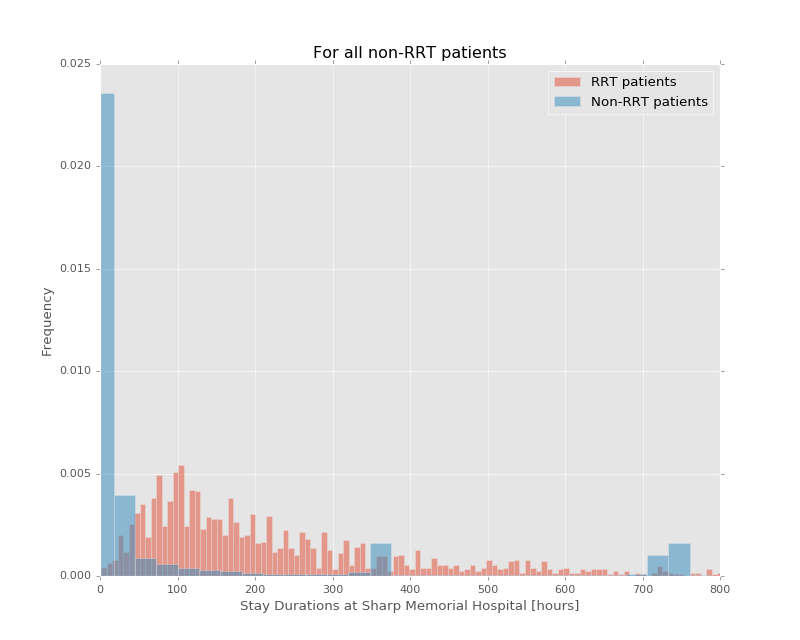

(0, 800)

In [249]:
plt.figure(figsize=(10,8))
df[df['loc_facility_cd']=='633867']['diff_hours'].plot.hist(alpha=0.5, bins=500,normed=True)
df_nrrt['diff_hours'].plot.hist(alpha=0.5, bins=900,normed=True)
plt.xlabel('Stay Durations at Sharp Memorial Hospital [hours]')
plt.legend(['RRT patients', 'Non-RRT patients'])
plt.title('For all non-RRT patients')
plt.xlim(0, 800)

<IPython.core.display.Javascript object>


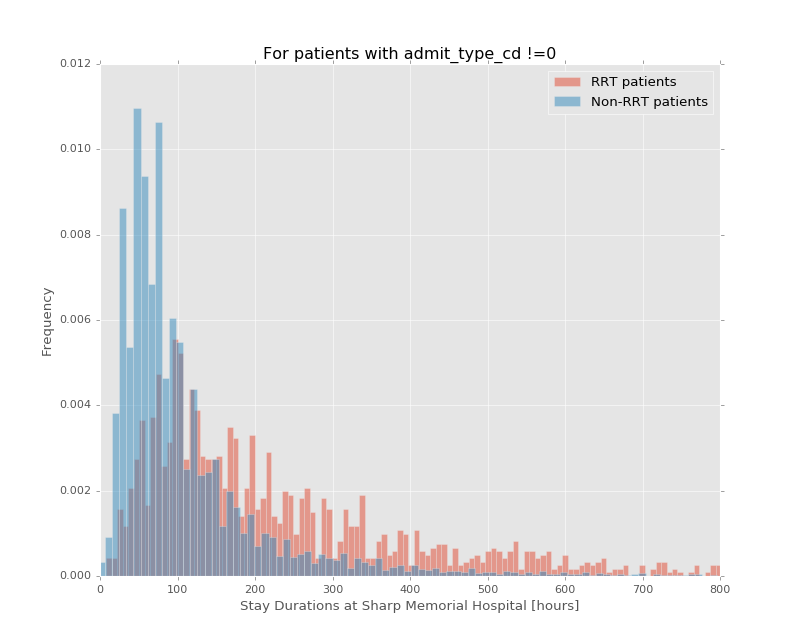

(0, 800)

In [225]:
plt.figure(figsize=(10,8))
df[df['loc_facility_cd']=='633867']['diff_hours'][df.admit_type_cd != '0'].plot.hist(alpha=0.5, bins=500,normed=True)
df_nrrt['diff_hours'][df_nrrt.admit_type_cd != '0'].plot.hist(alpha=0.5, bins=900,normed=True)
plt.xlabel('Stay Durations at Sharp Memorial Hospital [hours]')
plt.legend(['RRT patients', 'Non-RRT patients'])
plt.title('For patients with admit_type_cd !=0')
plt.xlim(0, 800)

<IPython.core.display.Javascript object>


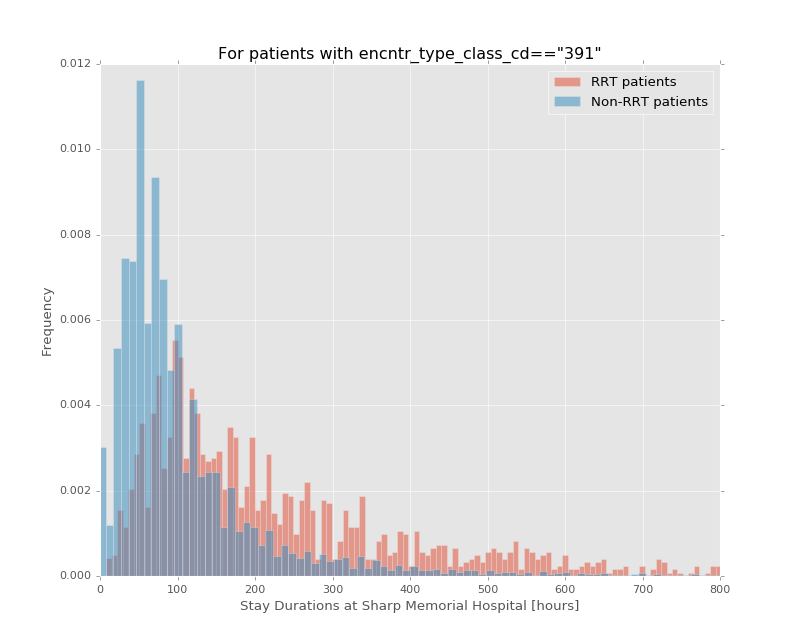

(0, 800)

In [250]:
plt.figure(figsize=(10,8))
df[df['loc_facility_cd']=='633867']['diff_hours'][df.encntr_type_class_cd=='391'].plot.hist(alpha=0.5, bins=500,normed=True)
df_nrrt['diff_hours'][df_nrrt.encntr_type_class_cd=='391'].plot.hist(alpha=0.5, bins=900,normed=True)
plt.xlabel('Stay Durations at Sharp Memorial Hospital [hours]')
plt.legend(['RRT patients', 'Non-RRT patients'])
plt.title('For patients with encntr_type_class_cd=="391"')
plt.xlim(0, 800)

<IPython.core.display.Javascript object>


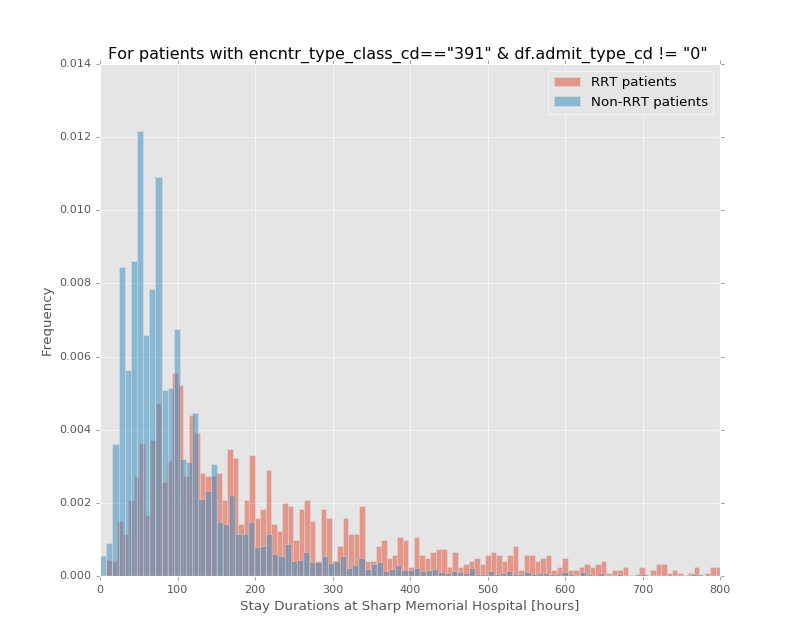

(0, 800)

In [239]:
plt.figure(figsize=(10,8))
df[df['loc_facility_cd']=='633867']['diff_hours'][(df.encntr_type_class_cd=='391') & (df.admit_type_cd != '0')].plot.hist(alpha=0.5, bins=500,normed=True)
df_nrrt['diff_hours'][(df_nrrt.encntr_type_class_cd=='391') & (df_nrrt.admit_type_cd != '0')].plot.hist(alpha=0.5, bins=1000,normed=True)
plt.xlabel('Stay Durations at Sharp Memorial Hospital [hours]')
plt.legend(['RRT patients', 'Non-RRT patients'])
plt.title('For patients with encntr_type_class_cd=="391" & df.admit_type_cd != "0" ')
plt.xlim(0, 800)

In [251]:
df_nrrt.describe()

,checkin_dt_tm,depart_dt_tm,diff_hours
count,4.827830e+05,4.827830e+05,482783.000000
mean,1.445066e+12,1.445533e+12,129.717734
std,1.650145e+10,1.650421e+10,300.147144
min,1.194500e+12,1.194517e+12,-7224.449722
25%,1.432457e+12,1.432970e+12,4.600000
50%,1.445358e+12,1.445695e+12,13.383333
75%,1.458254e+12,1.458828e+12,35.950000
max,1.471498e+12,1.471503e+12,17557.983333


In [253]:
# There are values of diff_hours that are negative.
df_nrrt[df_nrrt.diff_hours<0].count()

encntr_id               676
checkin_dt_tm           676
depart_dt_tm            676
diff_hours              676
reason_for_visit        676
admit_type_cd           676
admit_type_desc           1
encntr_type_cd          676
enc_type_desc           676
encntr_type_class_cd    676
enc_type_class_desc     676
admit_src_cd            676
admit_src_desc          607
loc_facility_cd         676
loc_desc                676
dtype: int64

In [255]:
# But, there are no such values after we correct for encounter type class & admit type
df_nrrt[(df_nrrt.encntr_type_class_cd=='391') & (df_nrrt.admit_type_cd != '0')][df_nrrt.diff_hours<0].count()

/opt/cloudera/parcels/Anaconda-4.0.0/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


encntr_id               0
checkin_dt_tm           0
depart_dt_tm            0
diff_hours              0
reason_for_visit        0
admit_type_cd           0
admit_type_desc         0
encntr_type_cd          0
enc_type_desc           0
encntr_type_class_cd    0
enc_type_class_desc     0
admit_src_cd            0
admit_src_desc          0
loc_facility_cd         0
loc_desc                0
dtype: int64